In [ ]:
 # Install classification_models from GitHub
!pip install git+https://github.com/qubvel/classification_models.git
!pip install tensorflow-addons

# Then import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.keras.mixed_precision.set_global_policy('mixed_float16') #enable mixed precision training
from tensorflow.keras import layers

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-a5ikaf28
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-a5ikaf28
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20029 sha256=4a768f6d3f67e0d9d257c1bd48235897b3d8ec69f4c1fba917955e15281f8d8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqol6v1c/wheels/14/43/ed/2d68b197c5260e7fe6b7d0fab20b997b6d365f6f5732316952
Successfully built image_classifiers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installat

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Zip your dataset in Drive first, then:
!cp /content/drive/MyDrive/augmented_resized_V2.zip /content/
!unzip -q /content/augmented_resized_V2.zip -d /content/augmented_resized_V2


Mounted at /content/drive


In [ ]:
# Paths
base_dir  = '/content/augmented_resized_V2'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Hyperparameters
IMG_SIZE      = (256, 256)
BATCH_SIZE    = 128
EPOCHS        = 15   #
NUM_CLASSES   = 5    # DR classes [0,1,2,3,4]
LEARNING_RATE = 1e-4


In [ ]:
def load_data(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)  # Resize once here
    image = image / 255.0
    return image, label

# Create tf.data.Dataset from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_resized_V2/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
).map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_resized_V2/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
).map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/augmented_resized_V2/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
).map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)


Found 115241 files belonging to 5 classes.
Found 14227 files belonging to 5 classes.
Found 14201 files belonging to 5 classes.


In [ ]:
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# base_model.trainable = False

# Optionally freeze some layers for faster training:
# freeze_until = 60
# for layer in base_model.layers[:freeze_until]:
#     layer.trainable = False


44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class PrimaryCaps(layers.Layer):
    """
    Converts final conv-layer features into a 2D capsule tensor: (batch, n_capsules, dim_capsule).
    """
    def __init__(self, capsule_dim=8, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.capsule_dim = capsule_dim
        self.dense = layers.Dense(self.capsule_dim)

    def call(self, inputs):
        # inputs shape: [batch, H, W, C]
        batch_size = tf.shape(inputs)[0]
        H = tf.shape(inputs)[1]
        W = tf.shape(inputs)[2]
        C = tf.shape(inputs)[3]

        # Flatten the spatial dimensions => (batch, H*W, C)
        x = tf.reshape(inputs, [batch_size, H*W, C])

        # Project channels to capsule_dim
        x = self.dense(x)  # => (batch_size, H*W, capsule_dim)
        return x


In [ ]:
class CapsuleGraphFusion(layers.Layer):
    """
    Applies multi-head self-attention over the capsules to learn inter-capsule relationships.
    """
    def __init__(self, d_model=16, num_heads=4, dropout_rate=0.1, **kwargs):
        super(CapsuleGraphFusion, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model   = d_model

        self.mha = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model)
        self.ffn = keras.Sequential([
            layers.Dense(self.d_model*4, activation='relu'),
            layers.Dense(self.d_model),
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.norm1    = layers.LayerNormalization(epsilon=1e-6)
        self.norm2    = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        # x: (batch, n_caps, d_caps)
        attn_output = self.mha(x, x, x)   # self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)    # Residual + norm

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.norm2(out1 + ffn_output)  # Residual + norm
        return out2


In [ ]:
def build_gf_capsnet(input_shape=(256, 256, 3), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # 1. ResNet-18 backbone
    x = base_model(inputs, training=False)  # shape ~ (batch, 7, 7, 512) for ResNet-18 on 224x224

    # 2. PrimaryCaps layer
    caps = PrimaryCaps(capsule_dim=16)(x)  # => (batch, 7*7, 16) = (batch, 49, 16)

    # 3. Multi-head self-attention
    fused_caps = CapsuleGraphFusion(d_model=16, num_heads=4, dropout_rate=0.1)(caps)

    # 4. Pool across the capsule dimension
    fused_caps = layers.GlobalAveragePooling1D()(fused_caps)

    # 5. Additional Dense + Dropout
    fused_caps = layers.Dropout(0.3)(fused_caps)
    fused_caps = layers.Dense(64, activation='relu')(fused_caps)
    fused_caps = layers.Dropout(0.2)(fused_caps)

    # 6. Output layer
    outputs = layers.Dense(num_classes, activation='softmax', dtype=tf.float32)(fused_caps)

    # Build model
    model = keras.Model(inputs, outputs, name='GF_CapsNet')
    return model


# Build & compile
gf_capsnet_model = build_gf_capsnet(input_shape=(256, 256, 3), num_classes=NUM_CLASSES)

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
gf_capsnet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
gf_capsnet_model.summary()


Model: "GF_CapsNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 8, 8, 512)           │      11,186,889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primary_caps (PrimaryCaps)           │ (None, 64, 16)              │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ capsule_graph_fusion                 │ (None, 64, 16)              │           6,496 │
│ (CapsuleGraphFusion)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,203,006 (42.74 MB)

 Trainable params: 11,195,064 (42.71 MB)

 Non-trainable params: 7,942 (31.02 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

checkpoint_path = "GF_CapsNet_best.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                    save_best_only=True, mode='max', verbose=1),
    CSVLogger("training_log.csv", append=True)
]

history = gf_capsnet_model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6202 - loss: 1.0250
Epoch 1: val_accuracy improved from -inf to 0.52850, saving model to GF_CapsNet_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 475s 352ms/step - accuracy: 0.6202 - loss: 1.0248 - val_accuracy: 0.5285 - val_loss: 1.7253
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7575 - loss: 0.6979
Epoch 2: val_accuracy improved from 0.52850 to 0.71983, saving model to GF_CapsNet_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 291s 323ms/step - accuracy: 0.7575 - loss: 0.6978 - val_accuracy: 0.7198 - val_loss: 0.7419
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8157 - loss: 0.5410
Epoch 3: val_accuracy did not improve from 0.71983
901/901 ━━━━━━━━━━━━━━━━━━━━ 255s 283ms/step - accuracy: 0.8157 - loss: 0.5410 - val_accuracy: 0.6754 - val_loss: 0.9079
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8769 - loss: 0.3808
Epoch 4: val_accuracy improved from 0.71983 to 0.

In [ ]:
gf_capsnet_model.load_weights(checkpoint_path)


In [ ]:
test_loss, test_acc = gf_capsnet_model.evaluate(
    test_ds,
    steps=len(test_ds),
    verbose=1
)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


In [ ]:
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 256, 256, 3)    │              0 │ data[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 256, 256, 3)    │              9 │ cast[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 128, 128, 64)   │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 128, 128, 64)   │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 64, 64, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 64, 64, 64)     │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 64, 64, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 11,186,889 (42.67 MB)

 Trainable params: 11,178,947 (42.64 MB)

 Non-trainable params: 7,942 (31.02 KB)

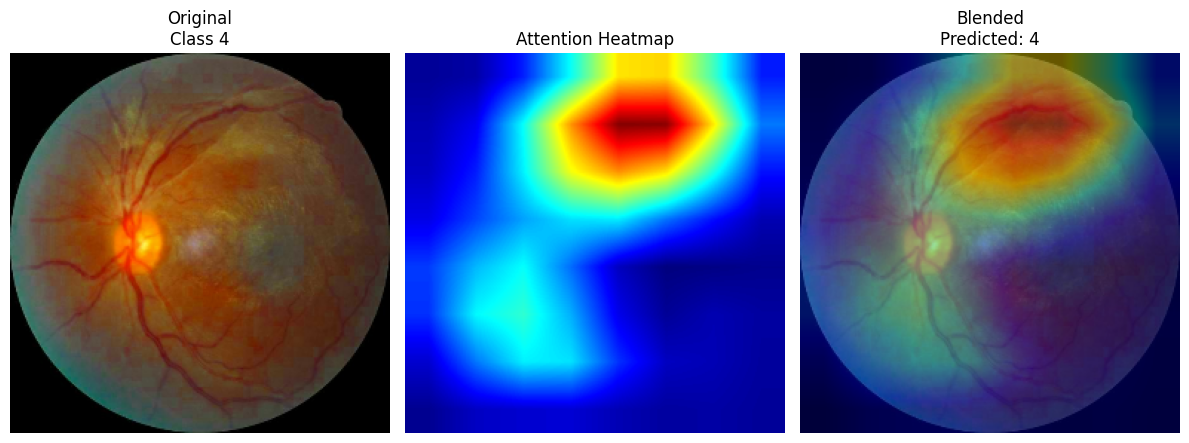

In [ ]:
!pip install opencv-python-headless
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf

# Get sample image from test dataset
for images, labels in test_ds.take(1):
    sample_image = images[0].numpy()
    sample_label = labels[0].numpy()
    break

# Preprocess and expand dimensions
img_array = tf.expand_dims(sample_image, axis=0)

# Get the specific last conv layer from base model.
# get the layer that is the output of the base model
last_conv_layer = gf_capsnet_model.get_layer('primary_caps').output

# Create gradient model
grad_model = tf.keras.models.Model(
    inputs=gf_capsnet_model.input,
    outputs=[gf_capsnet_model.output, last_conv_layer]
)

# Compute gradients
with tf.GradientTape() as tape:
    preds, conv_outputs = grad_model(img_array)
    pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

grads = tape.gradient(class_channel, conv_outputs)
# Modified line, keep the channel dimension
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Generate heatmap
conv_outputs = conv_outputs[0].numpy()
# Initialize heatmap with shape of capsules
heatmap = np.zeros(conv_outputs.shape[0], dtype=np.float32)
for i in range(conv_outputs.shape[0]): # Iterate over number of capsules
    for j in range(conv_outputs.shape[-1]): # Iterate over capsule dimension
        heatmap[i] += pooled_grads[j] * conv_outputs[i, j]


heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize and process heatmap
# Reshape to a square image before resizing.
heatmap = heatmap.reshape(8,8) # or another shape that when multiplied will give you 64
heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


# Prepare and blend images
original_img = (sample_image * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title(f'Original\nClass {sample_label}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Attention Heatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title(f'Blended\nPredicted: {pred_index.numpy()}')
plt.axis('off')

plt.tight_layout()
plt.show()